In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time,math,csv
import itertools
import collections

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# geo
import fiona
import shapely.geometry
from rtree import index

#simple-maps
sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

#migration-lib
sys.path.append(os.path.join(os.getcwd(),"migration-lib"))
import MigrationDataUSA
import MigrationModels
import EvaluationMethods

## Load migration data

In [2]:
migration_data = [
    np.load("data/migration/usa_migrationMatrix_%d.npy" % (year))
    for year in range(2004,2005+1)
]

for T in migration_data:
    np.fill_diagonal(T, 0)
    
outgoing_migration_data = [
    np.sum(T, axis=1)
    for T in migration_data
]

incoming_migration_data = [
    np.sum(T, axis=0)
    for T in migration_data
]

In [3]:
migration_counties = []
f = open("data/migration/largestCountyIntersection_2004_2014.txt")
for line in f.read().strip().split("\n"):
    migration_counties.append(line)
f.close()

In [4]:
populationDf = pd.read_csv("data/county_population_2004_2014.csv", dtype={"FIPS":str})
populationDf = populationDf.set_index("FIPS")

populationVectors = [populationDf[str(year)].as_matrix().reshape(-1,1) for year in [2004,2005]]

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [5]:
def calculate_percent_increase(T1, T2):
    ''' Solves T1 + (x)*T1 = T2 for x
    '''
    with np.errstate(divide='ignore', invalid='ignore'):
        percent_increase = np.divide((T2 - T1), T1)
    percent_increase[np.isnan(percent_increase)] = 0
    percent_increase[np.isinf(percent_increase)] = 0
    
    return percent_increase

In [6]:
percent_increase_outgoing = calculate_percent_increase(outgoing_migration_data[0], outgoing_migration_data[1])
percent_increase_incoming = calculate_percent_increase(incoming_migration_data[0], incoming_migration_data[1])

In [7]:
shapefileFn = "data/boundary_shapefiles/cb_2013_us_county_20m/cb_2013_us_county_20m.shp"
shapefileKey = "GEOID"

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


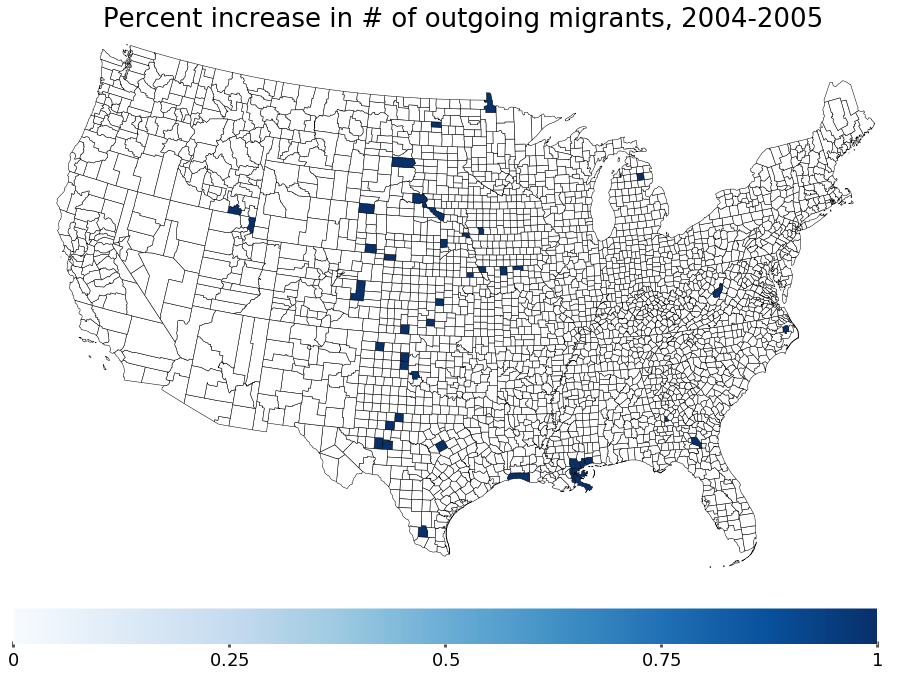

In [17]:
simpleMap(
    shapefileFn,
    shapefileKey,
    {
        #county: percent_increase_outgoing[i] * 100
        county: 1
        for i, county in enumerate(migration_counties)
        #if incoming_migration_data[0][i] > 40
        if populationVectors[0][i,0] > 500 and percent_increase_outgoing[i] > 0.9
    },
    #outputFn="outgoing.png",
    bounds=[22, 49, -119, -64],
    title="Percent increase in # of outgoing migrants, 2004-2005",
    colorbarRange=(0, 1),
    logScale=False,
)

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


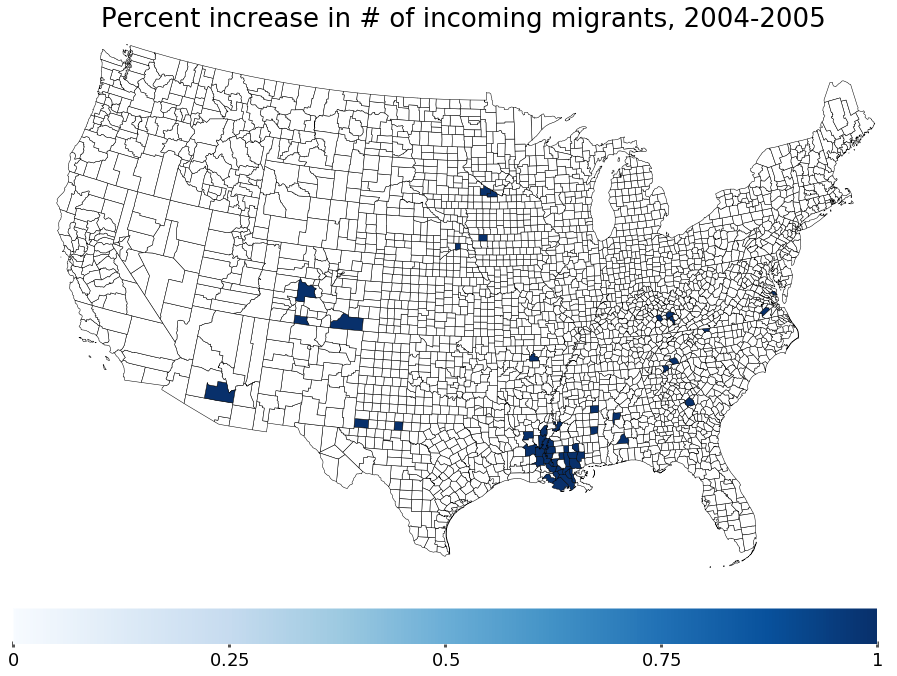

In [13]:
simpleMap(
    shapefileFn,
    shapefileKey,
    {
        #county: percent_increase_incoming[i] * 100
        county: 1
        for i, county in enumerate(migration_counties)
        #if incoming_migration_data[0][i] > 40
        if populationVectors[0][i,0] > 10000 and percent_increase_incoming[i] > 0.5
    },
    #outputFn="incoming.png",
    bounds=[22, 49, -119, -64],
    title="Percent increase in # of incoming migrants, 2004-2005",
    colorbarRange=(0, 1),
    logScale=False,
)

## Select training set counties

In [39]:
training_counties = []
training_counties_idx = []
for i in np.argsort(percent_increase_outgoing)[-50:][::-1]:
    if migration_counties[i].startswith("22") or migration_counties[i].startswith("28"):
        print(i, migration_counties[i], percent_increase_outgoing[i])
        
        if percent_increase_outgoing[i] > 1:
            training_counties.append(migration_counties[i])
            training_counties_idx.append(i)

1121 22087 12.694687983496648
1113 22071 6.181428939901986
1089 22023 3.5952380952380953
1115 22075 2.66068515497553
1388 28045 1.6557632398753894
1103 22051 1.4503510021365347
1389 28047 1.3365768463073853
1129 22103 0.9704966398950992


In [40]:
training_counties

['22087', '22071', '22023', '22075', '28045', '22051', '28047']

In [10]:
training_counties_check = [
    "22087", #St Bernard
    "22071", #Orleans
    "22023", #Cameron, affected by Hurricane Rita
    "22075", #Plaquemines
    "28045", #Hancock
    "22051", #Jefferson
    "28047", #Harrison
]
assert len(training_counties_check) == len(training_counties)
assert all([county in training_counties_check for county in training_counties])

training_counties_mask = [migration_counties.index(fip) for fip in training_counties]

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


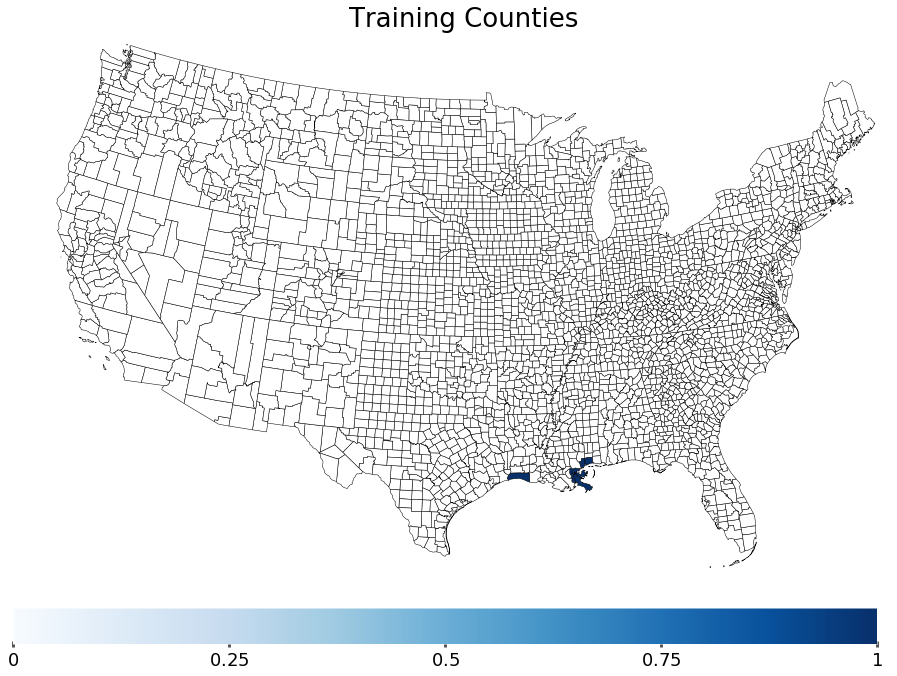

In [11]:
simpleMap(
    shapefileFn,
    shapefileKey,
    {county: 1 for county in training_counties},
    #outputFn="examples/demoSimpleFigureNormal.png",
    bounds=[22, 49, -119, -64],
    title="Training Counties",
    colorbarRange=(0,1),
    logScale=False,
)

In [26]:
f = open("data/katrina_rita_training_counties.txt","w")
f.write("\n".join(training_counties))
f.close()

## Check other migration data

In [32]:
f = open("data/usa_coastal_counties.csv","r")
coastal_county_set = set(map(lambda x: "%05d" % (int(x.split("|")[0])), f.read().strip().split("\n")))
f.close()

In [33]:
coastal_county_idxs = set()
for i,county in enumerate(migration_counties):
    if county in coastal_county_set:
        coastal_county_idxs.add(i)

In [18]:
migration_data = [
    np.load("data/migration/usa_migrationMatrix_%d.npy" % (year))
    for year in range(2004,2015)
]

for T in migration_data:
    np.fill_diagonal(T, 0)
    
outgoing_migration_data = [
    np.sum(T, axis=1)
    for T in migration_data
]

In [ ]:
22087", #St Bernard
    "22071", #Orleans
    "22023", #Cameron, affected by Hurricane Rita
    "22075", #Plaquemines
    "28045", #Hancock
    "22051", #Jefferson
    "28047", #Harrison

In [68]:
map_data = {}

for i in range(1, len(migration_data)):
    print(2004+i)
    
    percent_increase = calculate_percent_increase(outgoing_migration_data[i-1], outgoing_migration_data[i])
    
    for j, county in enumerate(migration_counties):
        prev_num_outgoing = np.sum(outgoing_migration_data[i-1][j])
        new_num_outgoing = np.sum(outgoing_migration_data[i][j])
        population = populationVectors[0][j,0]
        
        if prev_num_outgoing > 100 and percent_increase[j] > 1.0 and j in coastal_county_idxs and 2004+i != 2011:
            map_data[county] = 2004+i
    
    for j in np.argsort(percent_increase)[::-1]:
        prev_num_outgoing = np.sum(outgoing_migration_data[i-1][j])
        new_num_outgoing = np.sum(outgoing_migration_data[i][j])
        if percent_increase[j] < 1:
            break
        
        if prev_num_outgoing > 100:
            print("\t", prev_num_outgoing, new_num_outgoing, migration_counties[j], populationVectors[0][j,0], prev_num_outgoing, percent_increase[j])
            pass

2005
	 1939 26554 22087 70547 1939 12.694687983496648
	 19385 139212 22071 493765 19385 6.181428939901986
	 252 1158 22023 9851 252 3.5952380952380953
	 1226 4488 22075 29390 1226 2.66068515497553
	 1284 3410 28045 46717 1284 1.6557632398753894
	 19658 48169 22051 456602 19658 1.4503510021365347
	 8016 18730 28047 195971 8016 1.3365768463073853
2006
	 3015 6383 13179 63254 3015 1.1170812603648426
2007
	 351 741 48159 9731 351 1.1111111111111112
	 110 224 20151 9492 110 1.0363636363636364
2008
2009
2010
	 173 1130 13287 9310 173 5.531791907514451
	 7345 21426 04021 219472 7345 1.9170864533696392
	 166 366 08081 13175 166 1.2048192771084338
	 107 214 51595 5659 107 1.0
2011
	 110 349 51678 6810 110 2.172727272727273
	 105 318 48111 6208 105 2.0285714285714285
	 533 1552 47115 27769 533 1.9118198874296435
	 106 306 05137 11768 106 1.8867924528301887
	 214 609 54085 10415 214 1.8457943925233644
	 277 780 37173 13240 277 1.815884476534296
	 320 842 38105 19724 320 1.63125
	 729 1879 18107 3

In [69]:
map_data

{'13179': 2006,
 '22023': 2005,
 '22051': 2005,
 '22071': 2005,
 '22075': 2005,
 '22087': 2005,
 '28045': 2005,
 '28047': 2005}

/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.5/dist-packages/mpl_toolkits/basemap/__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


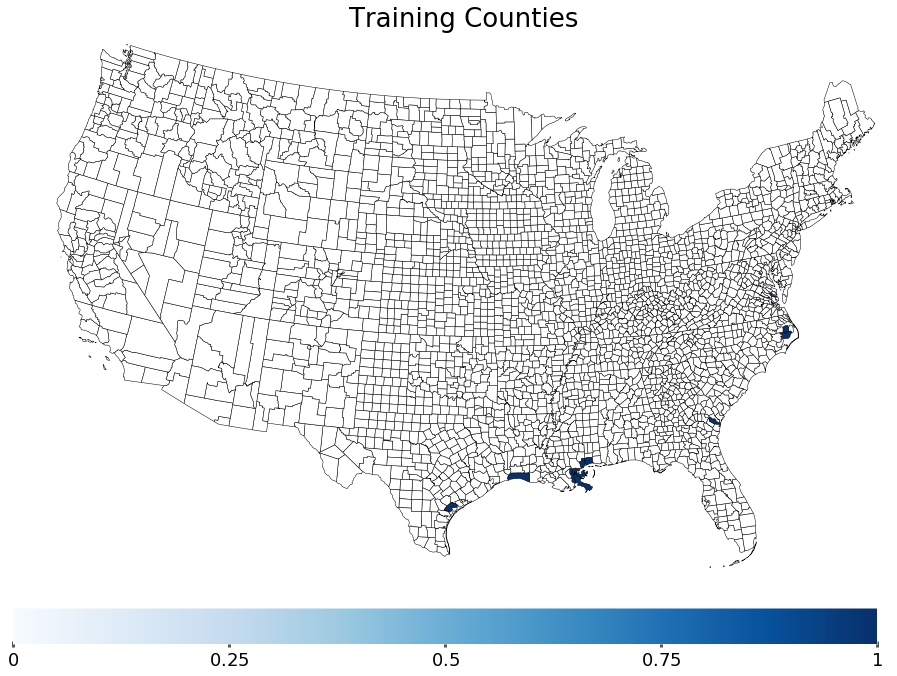

In [67]:
simpleMap(
    shapefileFn,
    shapefileKey,
    map_data,
    #outputFn="examples/demoSimpleFigureNormal.png",
    bounds=[22, 49, -119, -64],
    title="Training Counties",
    colorbarRange=(0,1),
    logScale=False,
)